In [1]:
!pip install --user --upgrade paramonte

In [1]:
import math
import scipy
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import genpareto
from scipy.stats import t as studentt
from statistics import mean
from scipy.optimize import minimize

import paramonte as pm
import seaborn as sns

In [2]:
 # SYNTHETIC DATA GENERATION

# generate single record (full tide, truncated tide, and proxy records)
def create_record(distribution , parameters, proxy_cutoffs): # set up as a function so other distributions could be used to generate data
        
    if distribution == 'student_t': # using student t-distribution
        
        # student's t-distribution parameters obtained by fitting to tide gauge record
        df = parameters[0]
        location = parameters[1]
        scale = parameters[2]
        
        # create timeline using one sample per day
        Nperyear = 365
        t1 = 1000
        t2 = 2020
        t = np.linspace(t1,t2,(t2-t1)*Nperyear+1)
        
        # sample water heights from student's t-distribution
        h = studentt.ppf(np.random.rand(len(t)), df, location, scale)
        q99 = studentt.ppf(0.99, df, location, scale)
        
        # generate pseudo-tide gauge record
        def msltrend(yr):
            trend = (yr - t2)*1.5
            return trend
        
        # create "true", unobservable, full tide gauge record
        fulltg_t = t
        fulltg_h_notrend = h
        fulltg_h = fulltg_h_notrend + msltrend(fulltg_t)
        fulltg_h = fulltg_h - statistics.mean(fulltg_h[np.where(fulltg_t >= 1983)])
        sub99 = np.where(fulltg_h_notrend >= q99)
        fulltg_t99 = fulltg_t[sub99]
        fulltg_h_notrend99 = fulltg_h_notrend[sub99]
        
        # create truncated tide gauge record (from 1920 on)
        tg_firstyear = 1920
        sub = np.where(fulltg_t >= tg_firstyear)
        tg_t = fulltg_t[sub]
        tg_h_notrend = fulltg_h_notrend[sub]
        tg_h = fulltg_h[sub]
        sub99 = np.where(tg_h_notrend >= q99)
        tg_t99 = tg_t[sub99]
        tg_h_notrend99 = tg_h_notrend[sub99]
        
        # generate geologic record -- using geologic cutoffs
        # using z w/o trend
        cutoff = proxy_cutoffs[0]
        proxysub = np.where(h >= cutoff)
        proxy_t_true = t[proxysub]
        proxy_h_true = h[proxysub]
        proxy_h = np.full((1, len(np.transpose(proxysub))), max(proxy_h_true)+100)
        
        # determine number of geologic events exceeding each geologic cutoff
        num_h_cutoff=[]
        for x in range(0,len(proxy_cutoffs)):
            cur_cutoff = proxy_cutoffs[x]
            proxysubset = np.where(h>=cur_cutoff)
            proxyheight = h[proxysubset]
            number_h = len(proxyheight)
            num_h_cutoff.append(number_h)
            
        num_tide_cutoff=[]
        for y in range(0,len(proxy_cutoffs)):
            cur_cutoff = proxy_cutoffs[y]
            tidesubset = np.where(tg_h_notrend99>=cur_cutoff)
            tideheight = tg_h_notrend99[tidesubset]
            number_th = len(tideheight)
            num_tide_cutoff.append(number_th)
            
        num_diff_cutoff=[]
        for z in range(0,len(num_h_cutoff)):
            a = num_h_cutoff[z] - num_tide_cutoff[z]
            num_diff_cutoff.append(a)
            
        # add in age error - making error increase with age
        # assume can determine true ages where geologic record overlaps with historical record
        proxy_dt = np.ones(len(proxy_t_true)) * 10 + 0.030 * (t2 - proxy_t_true)
        proxy_dt = proxy_dt * (proxy_t_true < 1800)

        proxy_t = proxy_t_true + np.random.randn(len(proxy_t_true)) * proxy_dt
        
        # calculate true number of exceedances from survival function
        # testz = list(np.arange(q99,5000,1))
        testz = list(np.arange(545, 3001, 1))
        logN = studentt.sf(testz, df, location, scale)*365
        
        testlogNexc = logN
        

        
        return [fulltg_t, fulltg_h_notrend, fulltg_h, tg_t, tg_h_notrend, tg_h, proxy_t_true, proxy_h_true, proxy_h, num_h_cutoff, q99, fulltg_t99, fulltg_h_notrend99, tg_t99, tg_h_notrend99, testz, testlogNexc, num_tide_cutoff, num_diff_cutoff]
    
    

In [3]:
# create list of records
def list_of_records(numrecords, distribution, parameters, proxy_cutoffs):

    records=[]
    for x in range(0,numrecords):
        a = create_record(distribution,parameters,proxy_cutoffs)
        records.append(a)
    return [records]

In [4]:
# generate record with student_t data
distribution = "student_t"
parameters = [9.365, 0.8957, 199.2]
proxy_cutoffs = [1250, 1350, 1450, 1650]

test_record = create_record(distribution, parameters, proxy_cutoffs)

fulltg_t = test_record[0]
fulltg_h_notrend = test_record[1]
fulltg_h = test_record[2]
tg_t = test_record[3]
tg_h_notrend = test_record[4]
tg_h = test_record[5]
proxy_t_true = test_record[6]
proxy_h_true = test_record[7]
proxy_h = test_record[8]
num_h_cutoff = test_record[9]
q99 = test_record[10]
fulltg_t_99 = test_record[11]
fulltg_h_notrend99 = test_record[12]
tg_t99 = test_record[13]
tg_h_notrend99 = test_record[14]
testz = test_record[15]
testlogNexc = test_record[16]
num_tide_cutoff = test_record[17]
num_diff_cutoff = test_record[18]


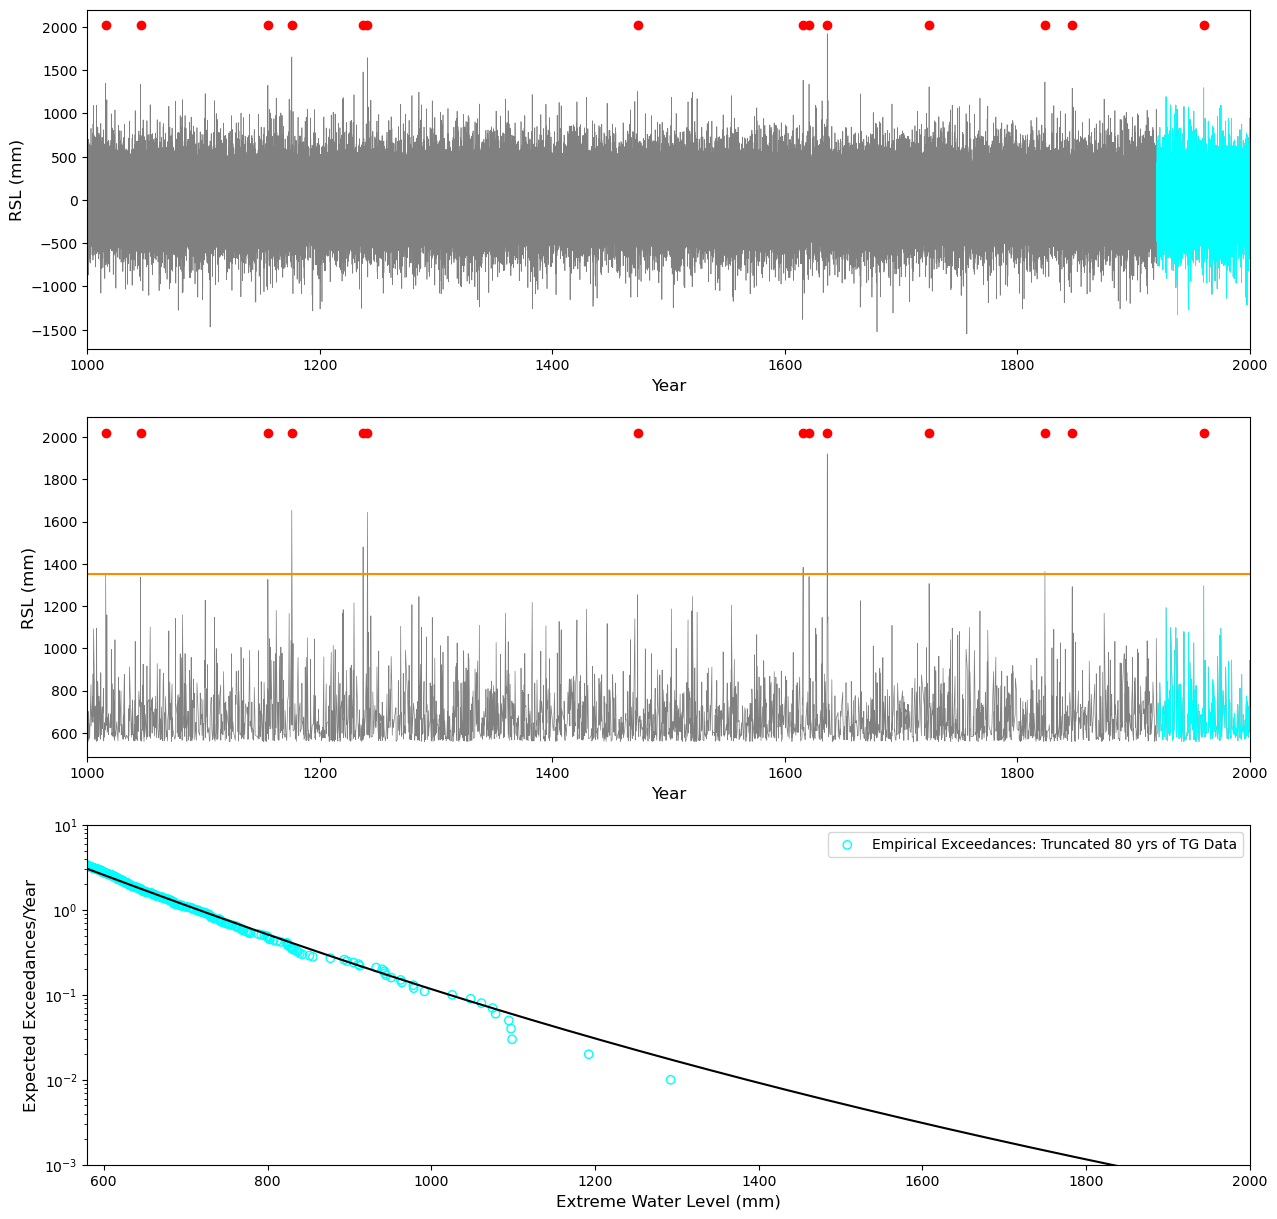

In [5]:
# explore data

# empirical exceedances
testexc_tg = tg_h_notrend99
    
exceeded_tide = []
for i in range(0, len(testexc_tg)):
    exc = sum(tg_h_notrend > testexc_tg[i])/(len(tg_h_notrend)/365.00)
    exceeded_tide.append(exc)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(311)
plt.plot(fulltg_t, fulltg_h_notrend, color = 'gray', linewidth = '0.5')
plt.plot(tg_t, tg_h_notrend, color = 'cyan', linewidth = '0.5')
plt.scatter(proxy_t_true, proxy_h, color = 'red') 
ax.set_xlim([1000,2000])
plt.xlabel('Year', fontsize = 12)
plt.ylabel('RSL (mm)', fontsize = 12)

# plt.savefig("StudentTDist_Data", bbox_inches = 'tight')

# fig = plt.figure(figsize=(15,10))
ax3 = fig.add_subplot(313)
plt.plot(testz, testlogNexc, color = 'black')
# plt.scatter(testexc, exceeded, facecolors = 'none', edgecolors = 'gray', label = 'Empirical Exceedances: Full 1000 yrs of SL Data')
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances: Truncated 80 yrs of TG Data')
ax3.set_yscale('log')
ax3.set_xlim([580, 2000])
ax3.set_ylim([1e-3, 10])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Expected Exceedances/Year', fontsize = 12)
plt.legend(loc = "upper right")

ax2 = fig.add_subplot(312)
plt.plot(fulltg_t_99, fulltg_h_notrend99, color = 'gray', linewidth = '0.5')
plt.plot(tg_t99, tg_h_notrend99, color = 'cyan', linewidth = '0.5')
plt.scatter(proxy_t_true, proxy_h, color = 'red')
x = (1000,2000)
# y = (1250,1250)
y2 = (1350,1350)
# y3 = (1450,1450)
# y4 = (1650,1650)
# plt.plot(x,y, color = 'coral')
plt.plot(x,y2, color = 'darkorange')
# plt.plot(x,y3, color = 'orangered')
# plt.plot(x,y4, color = 'firebrick')
ax2.set_xlim([1000,2000])
plt.xlabel('Year', fontsize = 12)
plt.ylabel('RSL (mm)', fontsize = 12)

plt.savefig("StationaryCase_SyntheticDataEx_ThesisFinal", bbox_inches = 'tight', dpi = 300)

In [6]:
df = pd.DataFrame(list(zip(testz, testlogNexc)),
               columns =['Water Level', 'N exc'])

df.head(1290)

,Water Level,N exc
0,545,4.082825
1,546,4.048805
2,547,4.015072
3,548,3.981622
4,549,3.948454
...,...,...
1285,1830,0.001003
1286,1831,0.000999
1287,1832,0.000994
1288,1833,0.000989


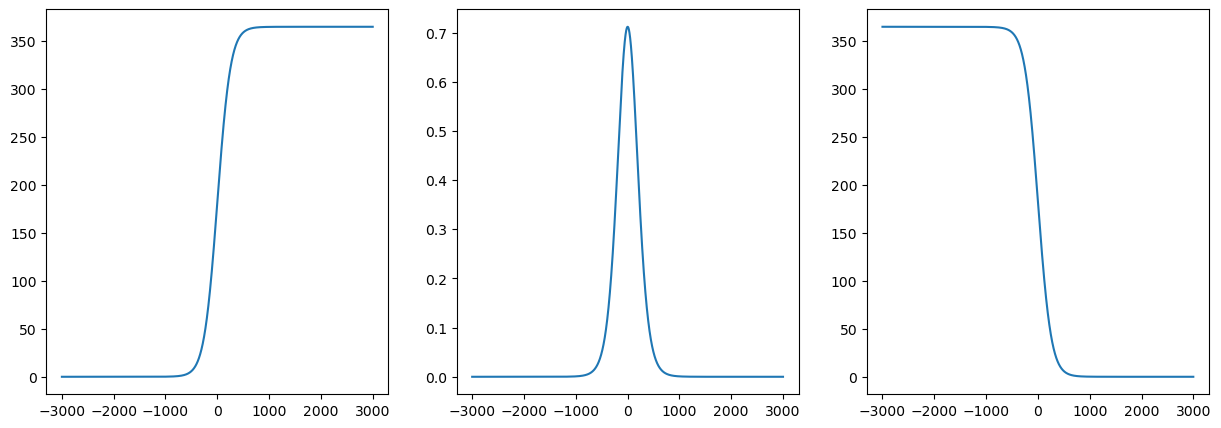

In [7]:
# CDF and PDF of true student's t-distribution

x = np.linspace(-3000, 3000, 6000)
y = studentt.cdf(x, 9.365, 0.8957, 199.2)*365
z = studentt.pdf(x, 9.365, 0.8957, 199.2)*365
zz = studentt.sf(x, 9.365, 0.8957, 199.2)*365

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax.plot(x,y)
ax2.plot(x,z)
ax3.plot(x,zz)


In [8]:
print(studentt.sf(1830, 9.365, 0.8957, 199.2)*365)

0.0010033737436608808


In [9]:
# generate list of 1000 records
numrecords = 1000
distribution = 'student_t'
parameters = [9.365, 0.8957, 199.2]
proxy_cutoffs = [1250, 1350, 1450, 1650]

records = list_of_records(numrecords, distribution, parameters, proxy_cutoffs)
records = records[0]

all_records = pd.DataFrame(records)


In [10]:
# define functions to be optimized (log likelihoods)

cutoff_data = test_record[18]  

geo_cutoffs = [1250, 1350, 1450, 1650]
geologic_id = 1

rec_num = 0

print(cutoff_data[geologic_id])

def function_a(z, mu, phi, xi): # just a funciton used in both likelihood functions
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def log_likelihood(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    q_99 = 558.4 # using as tide threshold
    
    M = cutoff_data[geologic_id] # number of geologic observations
    
    t1 = 1000
    t2 = 2000
    t_tide = 1920
    
    ll_geo_tide = ((-1 * len(all_records.loc[rec_num,14]) * np.log(phi)) +
        ((-1 - (1/xi)) * np.sum(function_a(all_records.loc[rec_num,14], mu, phi, xi))) -
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) -
        ((t2 - t_tide) * (1 + ((xi * (q_99 - mu))/phi))**(-1/xi)) -
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(ll_geo_tide) 

def log_likelihood_tide(parameters): # using tide gauge data only
    
    q_99 = 558.4
    
    t2 = 2000
    t_tide = 1920 # start of tide gauge record
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    ll_tide = ((-1 * len(all_records.loc[rec_num,14]) * np.log(phi)) +
        ((-1 - (1/xi)) * np.sum(function_a(all_records.loc[rec_num,14], mu, phi, xi))) -
        ((t2 - t_tide) * (1 + ((xi * (q_99 - mu))/phi))**(-1/xi)))
    
    return(ll_tide)


6


In [11]:
# test log likelihood function - testing with initial parameter values

parameters0 = [600, 130, 0.1, 1300]
parameters0_tide = [600, 130, 0.1]

ans = log_likelihood(parameters0)
print(ans)

ans1 = log_likelihood_tide(parameters0)
print(ans1)

-2283.856160738851
-2245.623461896245


In [12]:
# create MCMC samples for 1000 synthetic data sets

record_num = []

for x in range(len(all_records)):
    record_num.append(x)

def MCMCruns_geo():
    
    results_geo = []
    for i in range(0, len(record_num)):
        global rec_num
        rec_num = record_num[i]
        pmpd_geo = pm.ParaDRAM()
        pmpd_geo.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
        pmpd_geo.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
        pmpd_geo.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
        pmpd_geo.spec.variableNameList = ["mu", "phi", "xi", "tau"] # set the output names of the parameters.
        pmpd_geo.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
        pmpd_geo.spec.domainLowerLimitVec = [400, 100, 1e-10, 1000]
        pmpd_geo.spec.domainUpperLimitVec = [1000, 500, 1, 1500]
        pmpd_geo.runSampler(ndim = 4, # the number of parameters
                   getLogFunc = log_likelihood # the objective function to sample points from
                   )
        sample_geo = pmpd_geo.readSample(renabled = True)[0]
        results_geo.append(sample_geo)
    
    return(results_geo)

def MCMCruns_tide():
    
    results_tide = []
    for i in range(0, len(record_num)):
        global rec_num
        rec_num = record_num[i]
        pmpd_tide = pm.ParaDRAM()
        pmpd_tide.spec.overwriteRequested = True
        pmpd_tide.spec.outputFileName = "./out/ESL&GS_S_MCMC"
        pmpd_tide.spec.randomSeed = 12345
        pmpd_tide.spec.variableNameList = ["mu", "phi", "xi"]
        pmpd_tide.spec.chainSize = 20000
        pmpd_tide.spec.domainLowerLimitVec = [400, 100, 1e-10]
        pmpd_tide.spec.domainUpperLimitVec = [1000, 500, 1]
        pmpd_tide.runSampler(ndim = 3,
                    getLogFunc = log_likelihood_tide
                    )
        sample_tide = pmpd_tide.readSample(renabled = True)[0]
        results_tide.append(sample_tide)
        
    return(results_tide)



In [ ]:
results_geo = MCMCruns_geo()


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                    20000 / 100090             0.2688 / 0.1999             2.6429 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                     20000 / 95968             0.2728 / 0.2099             2.5527 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                    20000 / 102487             0.2780 / 0.1956             2.7675 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 101929             0.2658 / 0.1956             2.7261 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                     20000 / 98309             0.2791 / 0.2025             2.6428 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 101785             0.2607 / 0.1962             2.6468 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 100101             0.2565 / 0.1995             2.5747 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                         Accepted/Total Func. Call   Dynamic/Overall Acc. Rate   Elapsed/Remained Time [s] 
                         =========================   =========================   ========================= 
                                    20000 / 103948             0.2585 / 0.1925             2.7668 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simu

                                    20000 / 102200             0.2719 / 0.1953             2.6476 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 98792             0.2709 / 0.2039             2.5522 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 100186             0.3118 / 0.2012             2.5916 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 99853             0.2751 / 0.2003             2.5891 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                         Accepted/Total Func. Call   Dynamic/Overall Acc. Rate   Elapsed/Remained Time [s] 
                         =========================   =========================   ========================= 
                                     20000 / 93899             0.2724 / 0.2132             2.4065 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simu

                                    20000 / 101638             0.2603 / 0.1968             2.6270 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                     20000 / 89025             0.3439 / 0.2241             2.3167 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                     20000 / 94526             0.2716 / 0.2117             2.5167 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 97760             0.2811 / 0.2053             2.6641 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 89783             0.2842 / 0.2232             2.4089 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                         Accepted/Total Func. Call   Dynamic/Overall Acc. Rate   Elapsed/Remained Time [s] 
                         =========================   =========================   ========================= 
                                     20000 / 92202             0.2799 / 0.2181             2.4320 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simu

                                     20000 / 94891             0.2706 / 0.2112             2.4598 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 100289             0.2399 / 0.2006             2.6501 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                         Accepted/Total Func. Call   Dynamic/Overall Acc. Rate   Elapsed/Remained Time [s] 
                         =========================   =========================   ========================= 
                                     20000 / 92020             0.3405 / 0.2174             2.3416 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simu

                                     20000 / 99213             0.2428 / 0.2024             2.5755 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 102018             0.3352 / 0.1955             2.6324 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

 
        ParaDRAM - NOTE: Variable outputFileName detected among the input variables to ParaDRAM:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Absolute path to the current working directory:
        ParaDRAM - NOTE: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: Generating the requested directory for the ParaDRAM output files:
        ParaDRAM - NOTE: ./out/
        ParaDRAM - NOTE: 
        ParaDRAM - NOTE: ParaDRAM output files will be prefixed with:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC
 
 
 
        ParaDRAM - NOTE: Searching for previous runs of ParaDRAM...
 
 
 
        ParaDRAM - NOTE: No pre-existing ParaDRAM run detected.
        ParaDRAM - NOTE: Starting a fresh ParaDRAM run...
 
 
 
        ParaDRAM - NOTE: Generating the output report file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_report.txt
 
 
 
        P


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 96211             0.2791 / 0.2092             2.4841 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                    20000 / 100718             0.2632 / 0.1995             2.5711 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                     20000 / 87720             0.3013 / 0.2278             2.2290 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

                                      7714 / 45999             0.2293 / 0.1683             1.1566 / 1.8420

Exception ignored on calling ctypes callback function: <function ParaDRAM.runSampler.<locals>.getLogFunc2arg at 0x7f9890ed4280>
Traceback (most recent call last):
  File "/Users/kristenjoyse/.local/lib/python3.10/site-packages/paramonte/_paradram.py", line 552, in getLogFunc2arg
    return getLogFunc(PointVec)
  File "/var/folders/f6/515f_dp51v99cdlkbs5tpdbw0000gn/T/ipykernel_46405/4107320473.py", line 32, in log_likelihood
  File "<__array_function__ internals>", line 180, in sum
  File "/Users/kristenjoyse/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 2298, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/Users/kristenjoyse/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
KeyboardInterrupt: 


                                     7960 / 148999             0.0000 / 0.0535             4.1332 / 6.2517

Exception ignored on calling ctypes callback function: <function ParaDRAM.runSampler.<locals>.getLogFunc2arg at 0x7f9890ed4280>
Traceback (most recent call last):
  File "/Users/kristenjoyse/.local/lib/python3.10/site-packages/paramonte/_paradram.py", line 552, in getLogFunc2arg
    return getLogFunc(PointVec)
  File "/var/folders/f6/515f_dp51v99cdlkbs5tpdbw0000gn/T/ipykernel_46405/4107320473.py", line 31, in log_likelihood
  File "/Users/kristenjoyse/anaconda3/lib/python3.10/site-packages/pandas/core/indexing.py", line 1061, in __getitem__
    check_deprecated_indexers(key)
  File "/Users/kristenjoyse/anaconda3/lib/python3.10/site-packages/pandas/core/indexing.py", line 2672, in check_deprecated_indexers
    and any(isinstance(x, dict) for x in key)
  File "/Users/kristenjoyse/anaconda3/lib/python3.10/site-packages/pandas/core/indexing.py", line 2672, in <genexpr>
    and any(isinstance(x, dict) for x in key)
KeyboardInterrupt: 


                                     7961 / 202999             0.0000 / 0.0393             5.6666 / 8.5693

In [ ]:
results_tide = MCMCruns_tide()

In [ ]:
z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

coverage_ratio_tide66 = []
coverage_ratio_tide95 = []
    
for i in range(0, len(record_num)):
    runs = len(results_tide[i].df)
    coverage_ratio_count_tide66 = 0
    coverage_ratio_count_tide95 = 0
    
    for j in range(0, len(water_height_nums)-1):
        tidey = []
        
        for k in range(0, runs):
        
            # optimized parameter values
            mu = results_tide[i].df.loc[k, 'mu']
            phi = results_tide[i].df.loc[k, 'phi']
            xi = results_tide[i].df.loc[k, 'xi']
        
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            tidey.append(c)
        
        q2_5 = np.quantile(tidey, 0.025)
        q17 = np.quantile(tidey, 0.17)
        q50 = np.quantile(tidey, 0.50)
        q83 = np.quantile(tidey, 0.83)
        q97_5 = np.quantile(tidey, 0.975)
     
        if testlogNexc[j] > q17 and testlogNexc[j] < q83:
            coverage_ratio_count_tide66 = coverage_ratio_count_tide66 + 1
            
        if testlogNexc[j] > q2_5 and testlogNexc[j] < q97_5:
            coverage_ratio_count_tide95 = coverage_ratio_count_tide95 + 1
    
    coverage_ratio_count_tide66 = (coverage_ratio_count_tide66/len(water_height_nums))*100
    coverage_ratio_tide66.append(coverage_ratio_count_tide66)
    
    coverage_ratio_count_tide95 = (coverage_ratio_count_tide95/len(water_height_nums))*100
    coverage_ratio_tide95.append(coverage_ratio_count_tide95)
    

In [ ]:
# Coverage probabilities for tide gauge data - all water levels

# print(mean(coverage_ratio_tide66))
# print(mean(coverage_ratio_tide95))

coverage_ratio_tide66 = pd.DataFrame(coverage_ratio_tide66)
coverage_ratio_tide95 = pd.DataFrame(coverage_ratio_tide95)

coverage_ratio_tide66.describe()
# coverage_ratio_tide95.describe()


In [ ]:
plt.hist(coverage_ratio_tide95, bins = 25)
plt.show()

plt.hist(coverage_ratio_tide66, bins = 25)
plt.show()

In [ ]:
print(len(coverage_ratio_tide95))

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111) 

plt.scatter(x = record_num, y = coverage_ratio_tide66, color = 'lightsteelblue')
plt.scatter(x = record_num, y = coverage_ratio_tide95, color = 'cornflowerblue')

plt.plot((-1,1001), (66, 66), color = 'black', linestyle = (0, (5, 10)))
plt.plot((-1,1001), (90, 90), color = 'black', linestyle = (0, (5, 10)))

ax.set_xlim(-0.2,1000.2)
ax.set_ylim(0,100)


In [ ]:
# Coverage probabilities for geo + tide gauge data - all water levels

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

coverage_ratio66 = []
coverage_ratio95 = []
    
for i in range(0, len(record_num)):
    runs = len(results_geo[i].df)
    coverage_ratio_count66 = 0
    coverage_ratio_count95 = 0
    
    for j in range(0, len(water_height_nums)-1):
        geoy = []
        
        for k in range(0, runs):
        
            # optimized parameter values
            mu = results_geo[i].df.loc[k, 'mu']
            phi = results_geo[i].df.loc[k, 'phi']
            xi = results_geo[i].df.loc[k, 'xi']
        
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            geoy.append(c)
        
        q2_5 = np.quantile(geoy, 0.025)
        q17 = np.quantile(geoy, 0.17)
        q50 = np.quantile(geoy, 0.50)
        q83 = np.quantile(geoy, 0.83)
        q97_5 = np.quantile(geoy, 0.975)
     
        if testlogNexc[j] > q17 and testlogNexc[j] < q83:
            coverage_ratio_count66 = coverage_ratio_count66 + 1
            
        if testlogNexc[j] > q2_5 and testlogNexc[j] < q97_5:
            coverage_ratio_count95 = coverage_ratio_count95 + 1
    
    coverage_ratio_count66 = (coverage_ratio_count66/len(water_height_nums))*100
    coverage_ratio66.append(coverage_ratio_count66)
    
    coverage_ratio_count95 = (coverage_ratio_count95/len(water_height_nums))*100
    coverage_ratio95.append(coverage_ratio_count95)
    

In [ ]:
# Coverage probabilities for geo + tide gauge data - all water levels

print(mean(coverage_ratio66))
print(mean(coverage_ratio95))

In [ ]:
coverage_ratio66 = pd.DataFrame(coverage_ratio66)
coverage_ratio95 = pd.DataFrame(coverage_ratio95)

coverage_ratio66.describe()
coverage_ratio95.describe()

In [ ]:
plt.hist(coverage_ratio95, bins = 20)
plt.show()
plt.hist(coverage_ratio66, bins = 20)
plt.show()

In [ ]:
fig = plt.figure(figsize = (20,20))
tide67 = fig.add_subplot(221)
tide95 = fig.add_subplot(222)
geo67 = fig.add_subplot(223)
geo95 = fig.add_subplot(224)

tide67.hist(coverage_ratio_tide66, bins = 25)
tide95.hist(coverage_ratio_tide95, bins = 25)
geo67.hist(coverage_ratio66, bins = 25)
geo95.hist(coverage_ratio95, bins = 25)

tide67.set_xlim(0,100)
tide95.set_xlim(0,100)
geo67.set_xlim(0,100)
geo95.set_xlim(0,100)

tide67.set_ylim(0,250)
tide95.set_ylim(0,250)
geo67.set_ylim(0,250)
geo95.set_ylim(0,250)

geo67.set_xlabel('Coverage Ratio')
geo95.set_xlabel('Coverage Ratio')
tide67.set_ylabel('Number of Records')
geo67.set_ylabel('Number of Records')

plt.savefig("MCMC_CoverageRatioCompare.pdf", bbox_inches = 'tight', dpi = 300)

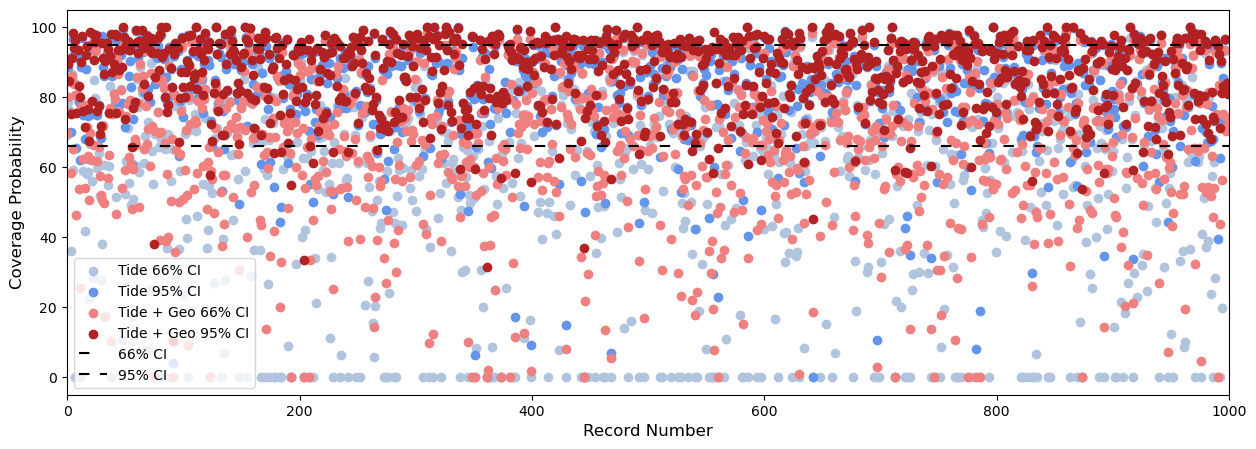

In [35]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111) 

plt.scatter(x = record_num, y = coverage_ratio_tide66, color = 'lightsteelblue', label = 'Tide 66% CI')
plt.scatter(x = record_num, y = coverage_ratio_tide95, color = 'cornflowerblue', label = 'Tide 95% CI')

plt.scatter(x = record_num, y = coverage_ratio66, color = 'lightcoral', label = 'Tide + Geo 66% CI')
plt.scatter(x = record_num, y = coverage_ratio95, color = 'firebrick', label = 'Tide + Geo 95% CI')

plt.plot((-1,1001), (66, 66), color = 'black', linestyle = (0, (5, 10)), label = '66% CI')
plt.plot((-1,1001), (95, 95), color = 'black', linestyle = (0, (5, 5)), label = '95% CI')

ax.set_xlim(-0.2,1000.2)
ax.set_ylim(-5,105)

ax.legend()
plt.xlabel('Record Number', fontsize = 12)
plt.ylabel('Coverage Probability', fontsize = 12)

plt.savefig("MCMC_CoverageProbs.pdf", bbox_inches = 'tight', dpi = 300)

In [51]:
coverage_ratio_tide90 = pd.DataFrame(coverage_ratio_tide90)
coverage_ratio90 = pd.DataFrame(coverage_ratio90)

hmdata = pd.concat([coverage_ratio_tide90, coverage_ratio90], axis=1)
hmdata

,0,0
0,89.332248,90.716612
1,96.824104,97.149837
2,68.851792,70.236156
3,93.811075,93.933225
4,97.353420,96.661238
...,...,...
95,80.089577,82.003257
96,82.899023,81.107492
97,92.833876,92.956026
98,97.882736,98.127036


<Axes: >

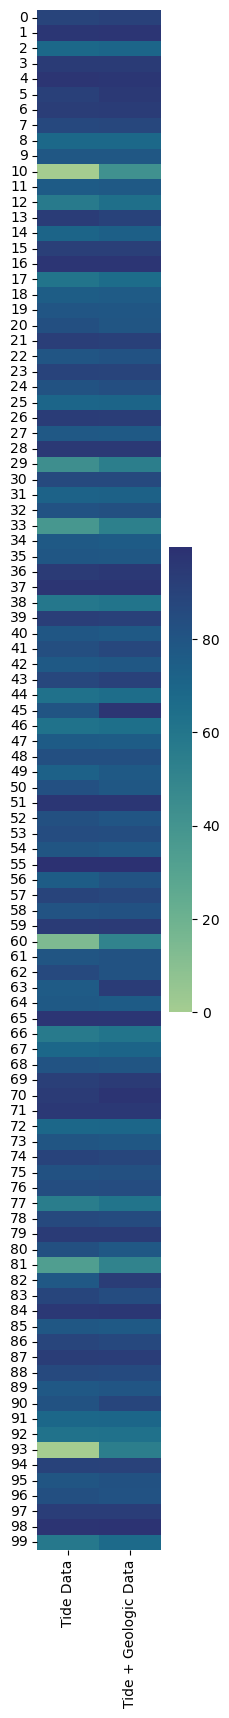

In [65]:
fig, ax = plt.subplots(figsize=(2, 20))

sns.heatmap(hmdata, cmap="crest", xticklabels = ['Tide Data', 'Tide + Geologic Data'])

In [ ]:
# Coverage probabilities for geo + tide gauge data - 1 in 100 year water level

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

coverage_ratio66 = []
coverage_ratio90 = []
    
for i in range(0, len(record_num)):
    runs = len(results_geo[i].df)
    coverage_ratio_count66 = 0
    coverage_ratio_count90 = 0
    
    for j in range(840, 841):
        geoy = []
        
        for k in range(0, runs):
        
            # optimized parameter values
            mu = results_geo[i].df.loc[k, 'mu']
            phi = results_geo[i].df.loc[k, 'phi']
            xi = results_geo[i].df.loc[k, 'xi']
        
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            geoy.append(c)
        
        q5 = np.quantile(geoy, 0.05)
        q17 = np.quantile(geoy, 0.17)
        q50 = np.quantile(geoy, 0.50)
        q83 = np.quantile(geoy, 0.83)
        q95 = np.quantile(geoy, 0.95)
     
        if testlogNexc[j] > q17 and testlogNexc[j] < q83:
            coverage_ratio_count66 = coverage_ratio_count66 + 1
            
        if testlogNexc[j] > q5 and testlogNexc[j] < q95:
            coverage_ratio_count90 = coverage_ratio_count90 + 1
    
    coverage_ratio_count66 = (coverage_ratio_count66/1)*100
    coverage_ratio66.append(coverage_ratio_count66)
    
    coverage_ratio_count90 = (coverage_ratio_count90/1)*100
    coverage_ratio90.append(coverage_ratio_count90)
    
    

In [ ]:
# Coverage probabilities for geo + tide gauge data - 1 in 100 year water level

print(mean(coverage_ratio66))
print(mean(coverage_ratio90))

In [ ]:
# Displaying coverage probabilities for geo + tide gauge data - 1 in 100 year water level

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

q5_in = []
q5_out = []
q17_out = []
q17_in = []
q83_in = []
q83_out = []
q95_in = []
q95_out = []
qs50 = []
i66_in = []
i66_out = []
i90_in = []
i90_out = []

for i in range(0, len(record_num)):
    runs = len(results_geo[i].df)
    coverage_ratio_count66 = 0
    coverage_ratio_count90 = 0
    
    for j in range(840, 841):
        geoy = []
        
        for k in range(0, runs):
        
            # optimized parameter values
            mu = results_geo[i].df.loc[k, 'mu']
            phi = results_geo[i].df.loc[k, 'phi']
            xi = results_geo[i].df.loc[k, 'xi']
        
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            geoy.append(c)
        
        q5 = np.quantile(geoy, 0.05)
        q17 = np.quantile(geoy, 0.17)
        q50 = np.quantile(geoy, 0.50)
        qs50.append(q50)
        q83 = np.quantile(geoy, 0.83)
        q95 = np.quantile(geoy, 0.95)
        
        if testlogNexc[j] > q17 and testlogNexc[j] < q83:
            q17_in.append(q17)
            q83_in.append(q83)
            i66_in.append(record_num[i])
        else:
            q17_out.append(q17)
            q83_out.append(q83)
            i66_out.append(record_num[i])
            
        if testlogNexc[j] > q5 and testlogNexc[j] < q95:
            q5_in.append(q5)
            q95_in.append(q95)
            i90_in.append(record_num[i])
        else:
            q5_out.append(q5)
            q95_out.append(q95)
            i90_out.append(record_num[i])
        
    a1 = np.array(q83_in)
    a2 = np.array(q17_in)
    height66_in = np.subtract(a1, a2)
    a3 = np.array(q83_out)
    a4 = np.array(q17_out)
    height66_out = np.subtract(a3, a4)
    
    a5 = np.array(q95_in)
    a6 = np.array(q5_in)
    height90_in = np.subtract(a5, a6)
    a7 = np.array(q95_out)
    a8 = np.array(q5_out)
    height90_out = np.subtract(a7, a8)

     

In [ ]:
# Displaying coverage probabilities for geo + tide gauge data - 1 in 100 year water level - 66 CI

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111) 

plt.bar(x = i66_in, height = height66_in, bottom = q17_in, color = 'cornflowerblue', label = 'Truth Within 17-83 CI')
plt.bar(x = i66_out, height = height66_out, bottom = q17_out, color = 'lightcoral', label = 'Truth Outside 17-83 CI')
plt.plot((-1,1000), (0.010, 0.010), color = 'black', linewidth = 0.5, label = 'True Value')

# ax.set_ylim([0.002, 0.030])
ax.set_xlim([-1, 10])
plt.legend()
plt.xlabel('Record Number')
plt.ylabel('Expected Annual Exceedances')
plt.savefig("coverage_probability_66.pdf", bbox_inches = 'tight', dpi = 300)

In [ ]:
# Displaying coverage probabilities for geo + tide gauge data - 1 in 100 year water level - 90 CI

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111) 

plt.bar(x = i90_in, height = height90_in, bottom = q5_in, color = 'cornflowerblue', label = 'Truth Within 5-95 CI')
plt.bar(x = i90_out, height = height90_out, bottom = q5_out, color = 'lightcoral', label = 'Truth Outside 5-95 CI')
plt.plot((-1,1000), (0.010, 0.010), color = 'black', linewidth = 0.5, label = 'True Value')

# ax.set_ylim([0.002, 0.034])
ax.set_xlim([-1, 10])
plt.legend()

plt.xlabel('Record Number')
plt.ylabel('Expected Annual Exceedances')
plt.savefig("coverage_probability_90.pdf", bbox_inches = 'tight', dpi = 300)

In [ ]:
# Displaying coverage probabilities for geo + tide gauge data - 1 in 100 year water level - Median values


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111) 

plt.scatter(x = record_num, y = qs50, color = 'cornflowerblue', label = 'Median')
plt.plot((-1,1000), (0.010, 0.010), color = 'black', linewidth = 0.5, label = 'True Value')

# ax.set_ylim([0.002, 0.034])
ax.set_xlim([-1, 10])
plt.legend()

plt.xlabel('Record Number')
plt.ylabel('Expected Annual Exceedances')
plt.savefig("coverage_probability_50.pdf", bbox_inches = 'tight', dpi = 300)

In [ ]:
# Inverse of quantiles for tide + geo data

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)
    
geoy = []
    
for i in range(0, len(record_num)):
    
#     for j in range(840, 841):
    for j in range(1285, 1286):

        u = results_geo[i].df.describe()
        
        # optimized parameter values
        mu = u.loc['50%', 'mu']
        phi = u.loc['50%', 'phi']
        xi = u.loc['50%', 'xi']
        
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        geoy.append(c)
            
                

In [ ]:
q_of_true = []

for i in range(0, len(geoy)):
    
    k = studentt.cdf(geoy[i], 9.365, 0.8957, 199.2)
    q_of_true.append(k)
    

In [ ]:
print(geoy)

In [ ]:
print(q_of_true)

In [ ]:
lenruns = []
for i in range(0, 10):
    lenruns.append(i)  

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.scatter(x = lenruns, y = q_of_true, color = 'cornflowerblue', label = 'Median')

ax.set_ylim(0,1)